In [ ]:
# ==========================================
# CENG 476 - Deep Learning Project
# Group Members: Kadir ADIMUTLU (210444003), Muhammed YILDIZ (210444052), Doğan ÇAKIR (210444075)
# Project: Fake News Detection using Ensemble Deep Learning (LSTM + BERT)
# ==========================================

import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Transformers (BERT)
try:
    import transformers
except ImportError:
    !pip install -q transformers
    import transformers

from transformers import BertTokenizer, TFBertForSequenceClassification

# Set Seeds for Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries Imported & Environment Ready.")

✅ Libraries Imported & Environment Ready.


In [ ]:
import os
import pandas as pd
from google.colab import files

print("Current Directory Contents:", os.listdir())

# Automatic Upload (If Fake.csv isn't found, this will help to upload it.)
if not os.path.exists('Fake.csv'):
    print("\n⚠️ 'Fake.csv' not found! Opening upload window...")
    print("Please upload 'Fake.csv' now.")
    files.upload()
# Same thing for True.csv
if not os.path.exists('True.csv'):
    print("\n⚠️ 'True.csv' not found! Opening upload window...")
    print("Please upload 'True.csv' now.")
    files.upload()

# It fixes the problem of lowercase and uppercase on filenames. (Such as True.csv and true.csv)
def load_csv_robust(filename):
    if os.path.exists(filename):
        return pd.read_csv(filename)
    elif os.path.exists(filename.lower()):
        print(f"Found '{filename.lower()}' instead of '{filename}'. Loading that.")
        return pd.read_csv(filename.lower())
    else:
        raise FileNotFoundError(f"❌ CRITICAL ERROR: Could not find {filename} even after upload.")

df_fake = load_csv_robust('Fake.csv')
df_true = load_csv_robust('True.csv')

print("\n✅ FILES LOADED SUCCESSFULLY!")

# Preprocessing
df_fake["class"] = 0
df_true["class"] = 1

df_combined = pd.concat([df_fake, df_true], axis=0)
df_combined["text_merged"] = df_combined["title"] + " " + df_combined["text"]
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

import re
import string
def wordopt(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r"\\W", " ", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

print("Cleaning data...")
df_combined["text_clean"] = df_combined["text_merged"].apply(wordopt)

from sklearn.model_selection import train_test_split
X = df_combined["text_clean"]
y = df_combined["class"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"✅ Data Prepared:\n- Train: {len(X_train)}\n- Val: {len(X_val)}\n- Test: {len(X_test)}")

Current Directory Contents: ['.config', 'sample_data']

⚠️ 'Fake.csv' not found! Opening upload window...
Please upload 'Fake.csv' now.


Saving Fake.csv to Fake.csv

⚠️ 'True.csv' not found! Opening upload window...
Please upload 'True.csv' now.


Saving True.csv to True.csv

✅ FILES LOADED SUCCESSFULLY!
Cleaning data...
✅ Data Prepared:
- Train: 31428
- Val: 6735
- Test: 6735


In [ ]:
# Constants
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 250

# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)

# Build LSTM Architecture
model_lstm = Sequential([
    Embedding(MAX_VOCAB_SIZE, 128, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64)), # Bi-Directional for better context
    Dropout(0.5),            # Regularization
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Starting LSTM Training...")
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop],
    verbose=1
)
print("✅ LSTM Training Complete.")

Starting LSTM Training...
Epoch 1/10
492/492 [==============================] - 64s 118ms/step - loss: 0.1603 - accuracy: 0.9416 - val_loss: 0.3096 - val_accuracy: 0.9125
Epoch 2/10
492/492 [==============================] - 26s 52ms/step - loss: 0.0668 - accuracy: 0.9801 - val_loss: 0.0433 - val_accuracy: 0.9865
Epoch 3/10
492/492 [==============================] - 15s 30ms/step - loss: 0.0795 - accuracy: 0.9741 - val_loss: 0.1073 - val_accuracy: 0.9696
Epoch 4/10
492/492 [==============================] - 15s 31ms/step - loss: 0.0560 - accuracy: 0.9836 - val_loss: 0.0672 - val_accuracy: 0.9785
Epoch 5/10
492/492 [==============================] - 15s 31ms/step - loss: 0.0275 - accuracy: 0.9927 - val_loss: 0.0411 - val_accuracy: 0.9877
Epoch 6/10
492/492 [==============================] - 13s 27ms/step - loss: 0.0265 - accuracy: 0.9916 - val_loss: 0.0501 - val_accuracy: 0.9883
Epoch 7/10
492/492 [==============================] - 13s 26ms/step - loss: 0.0761 - accuracy: 0.9753 - val_l

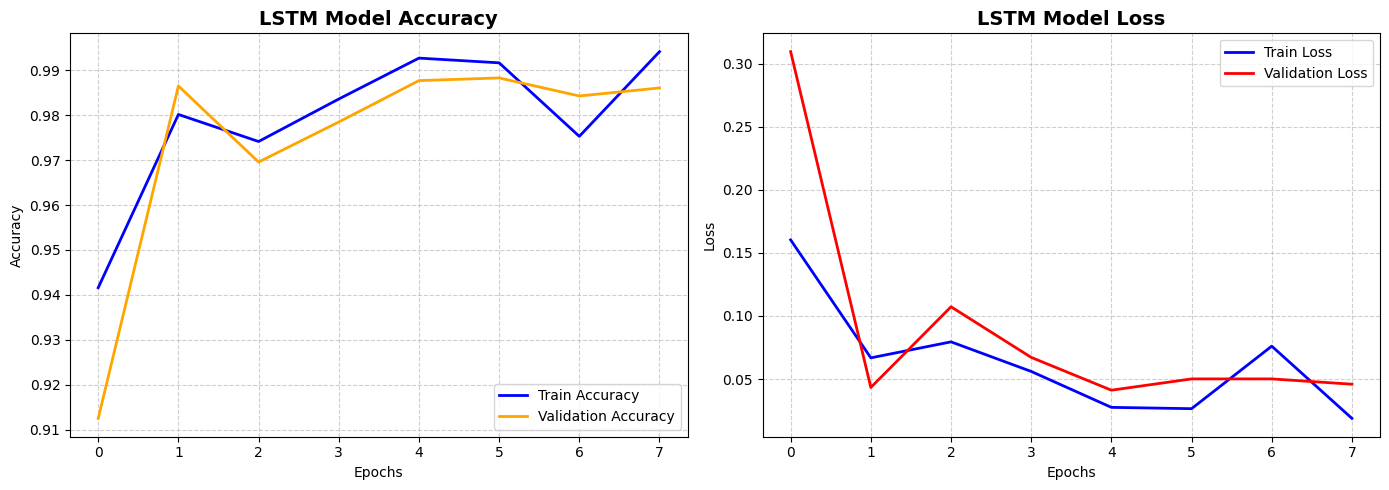

In [ ]:
import matplotlib.pyplot as plt

# Set up the visual style
plt.figure(figsize=(14, 5))

# PLOT 1: ACCURACY
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
plt.title('LSTM Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

# PLOT 2: LOSS
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('LSTM Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
# BERT Tokenization
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN_BERT = 128

def bert_encode(data, max_len):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded = tokenizer_bert.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

print("Encoding data for BERT (approx. 2 mins)...")
train_ids, train_masks = bert_encode(X_train.values, MAX_LEN_BERT)
val_ids, val_masks = bert_encode(X_val.values, MAX_LEN_BERT)
test_ids, test_masks = bert_encode(X_test.values, MAX_LEN_BERT)

# Build BERT Model
model_bert = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=1, use_safetensors=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.keras.metrics.BinaryAccuracy('accuracy')

model_bert.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train BERT
print("Starting BERT Training...")
history_bert = model_bert.fit(
    [train_ids, train_masks], y_train,
    validation_data=([val_ids, val_masks], y_val),
    epochs=2,
    batch_size=32
)
print("✅ BERT Training Complete.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Encoding data for BERT (approx. 2 mins)...


tf_model.h5:   0%|          | 0.00/536M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting BERT Training...
Epoch 1/2
983/983 [==============================] - 908s 871ms/step - loss: 0.0254 - accuracy: 0.9914 - val_loss: 0.0034 - val_accuracy: 0.9994
Epoch 2/2
983/983 [==============================] - 863s 878ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0026 - val_accuracy: 0.9997
✅ BERT Training Complete.


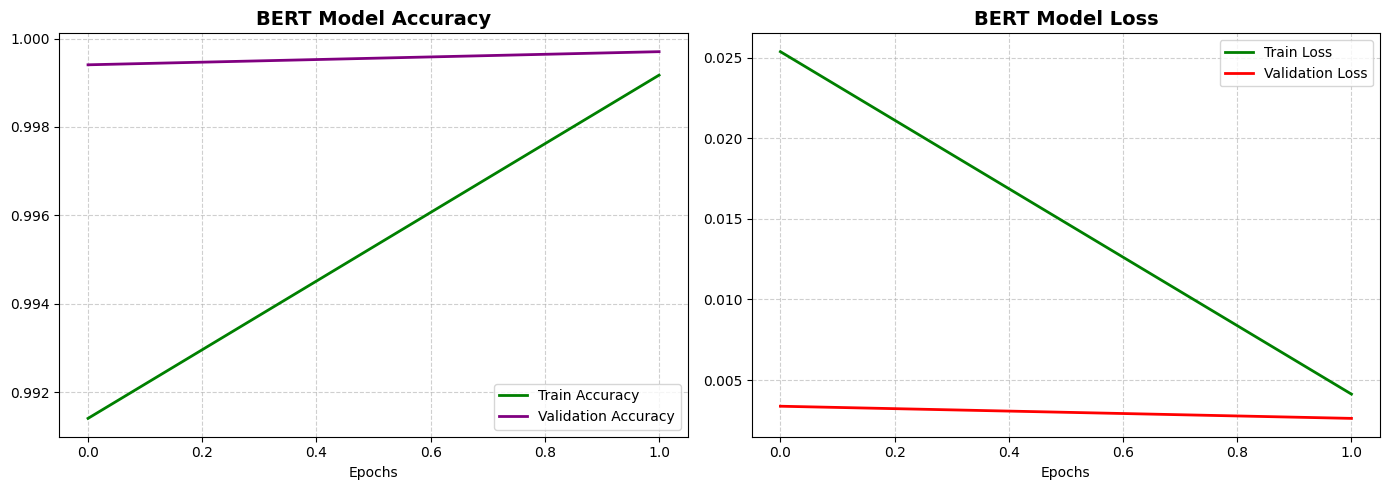

In [8]:
plt.figure(figsize=(14, 5))

# BERT Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_bert.history['accuracy'], label='Train Accuracy', color='green', linewidth=2)
plt.plot(history_bert.history['val_accuracy'], label='Validation Accuracy', color='purple', linewidth=2)
plt.title('BERT Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# BERT Loss
plt.subplot(1, 2, 2)
plt.plot(history_bert.history['loss'], label='Train Loss', color='green', linewidth=2)
plt.plot(history_bert.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('BERT Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Calculating Ensemble Predictions...
211/211 [==============================] - 64s 283ms/step

★ FINAL ENSEMBLE ACCURACY: 99.93% ★

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3547
        True       1.00      1.00      1.00      3188

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



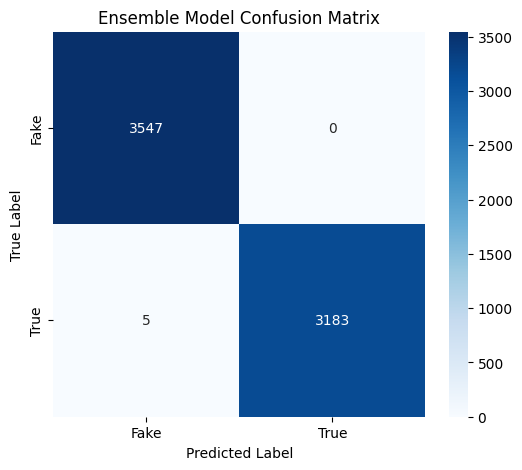

In [ ]:
# Generate Predictions
print("Calculating Ensemble Predictions...")

# LSTM Predictions
pred_lstm = model_lstm.predict(X_test_pad)

# BERT Predictions (Logits -> Sigmoid)
pred_bert_logits = model_bert.predict([test_ids, test_masks]).logits
pred_bert = tf.nn.sigmoid(pred_bert_logits).numpy()

# Weighted Ensemble / Combining models (50% LSTM + 50% BERT)
ensemble_pred_prob = (0.5 * pred_lstm) + (0.5 * pred_bert)
ensemble_pred_class = (ensemble_pred_prob > 0.5).astype(int)

# Metrics & Report
final_acc = accuracy_score(y_test, ensemble_pred_class)
print(f"\n{'='*40}")
print(f"★ FINAL ENSEMBLE ACCURACY: {final_acc*100:.2f}% ★")
print(f"{'='*40}\n")

print(classification_report(y_test, ensemble_pred_class, target_names=['Fake', 'True']))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, ensemble_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Ensemble Model Confusion Matrix')
plt.show()